## Initialize

In [1]:
%matplotlib inline

import pickle, os, sys

import numpy as np
import random

from deap import creator, gp, base, tools
import librosa

import yaml

import soundfile as sf
import matplotlib.pyplot as plt
import pygraphviz as pgv
plt.ion()

from ipywidgets import interactive, interact
import ipywidgets as widgets
import IPython.display as ip_disp
from  IPython.display import HTML

from supriya import SynthDefBuilder, CalculationRate
from supriya.ugens import Out, K2A
import numbers

# Necessary to be able to import code from the main Python files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gensynth.supercollider.synthesis import initialize_synthesis_dirs, synthesize_sounds
initialize_synthesis_dirs()

import nest_asyncio
nest_asyncio.apply()

run_name = None
config_file = None

## Generate Data

In [3]:
config_directory = '../configs/merge_operator_experiment/'
config_files = sorted(os.listdir(config_directory))

config_widget = widgets.Dropdown(options=config_files, description='Config:', value=config_file)

def reload_configs(event):
    config_files = sorted(os.listdir(config_directory))
    config_widget.options = config_files

reload_widget = widgets.Button(description='Reload')
reload_widget.on_click(reload_configs)

display(widgets.HBox([reload_widget, config_widget]))

In [103]:
# %%bash -s {config_widget.value}
# cd ..
# echo $1
# eval "$(micromamba shell hook --shell bash)"
# export PYTHONPATH="${PYTHONPATH}:./gensynth"
# python gensynth/simple_run.py --config ./configs/$1
# cd notebooks

## Load Data

In [153]:
log_directory = '../logs/pickle/merge_experiment/merge_with_one_point/'
log_directories = sorted(os.listdir(log_directory))
run_widget = widgets.Dropdown(options=log_directories, description='Run:')
display(run_widget)

#from ipylab import JupyterFrontEnd
#app = JupyterFrontEnd()
#await app.ready()
#app.commands.execute("notebook:move-cursor-down")
#app.commands.execute('notebook:run-all-below')

Dropdown(description='Run:', options=('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', …

In [166]:
run_name = run_widget.value
run_directory = log_directory + run_name + '/'

with open(run_directory + "/config.yaml", "r") as file:
    config = yaml.safe_load(file)

sample_rate = config['target_audio']['sample_rate']
population_size = config['evolutionary_algorithm']['population_size']
hall_of_fame_size = config['evolutionary_algorithm']['selection']['hall_of_fame_size']
fitness_count = len(config['evolutionary_algorithm']['fitness_function']['feature'])
use_multiple_objectives = fitness_count > 1

# Fix for DEAP storing ephemeral stuff globally and complaining about redefining them.
gp_global_variables = gp.__dict__
if "frequency" in gp_global_variables:
    del gp_global_variables["frequency"]
if "multiplier" in gp_global_variables:
    del gp_global_variables["multiplier"]

# Define the classes necessary for de-pickling
if config['jax']['use_jax_implementation']:
    from gensynth.differentiable.representation import get_primitive_set
    primitive_set = get_primitive_set(config['jax']['parameter_count'])
else:
    from gensynth.supercollider.representation import get_primitive_set
    primitive_set = get_primitive_set()

creator.create("FitnessMin", base.Fitness, weights=[-1.0] * fitness_count)
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=primitive_set)

populations = []

last_generation = 0

# Iterate through all files in the directory and load the individual populations
for f in os.listdir(os.fsencode(run_directory)):
    file_name = os.fsdecode(f)
    
    if not file_name.endswith('.pkl'):
        continue
    
    generation_index = int(file_name.rsplit('.')[0], base=10)
    last_generation = max(last_generation, generation_index)
    
    file = open(run_directory + file_name, 'rb')
    population = pickle.load(file)
    file.close()
    
    new_stats = []
    for index, individual in enumerate(population):
        individual_stats = {}
        individual_stats['generation'] = generation_index
        individual_stats['individual'] = index

        for fitness_index, fitness in enumerate(individual.fitness.values):
            individual_stats[f'fitness_{fitness_index}'] = float(fitness)
        
        individual_stats['depth'] = individual.height
        individual_stats['valid'] = not np.isinf(individual.fitness.values[0])
        #if use_multiple_objectives:
        #    individual_stats['crowding_distance'] = individual.fitness.crowding_dist
        
        individual_stats['expression'] = str(individual)
        
        new_stats.append(individual_stats)
    
    populations.extend(new_stats)

/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [167]:
import pandas as pd

df = pd.DataFrame(populations)
df.head()

generation  individual     fitness_0    fitness_1  fitness_2  fitness_3  \
0         155           0  17799.941406  6398.720703   0.157143        3.0   
1         155           1   7063.994141  4627.272461   1.628571        1.0   
2         155           2  14133.391602  6861.125488   0.214286        2.0   
3         155           3  12394.595703  6199.918945   0.985714        0.0   
4         155           4  18241.945312  5842.554199   0.242857        2.0   

   depth  valid                                         expression  
0      3   True  mul(BPFKR(0.8690841007567635, 9379.0, 1.256640...  
1      1   True                    SinOscAR(356.0, BrownNoiseKR())  
2      2   True  mul(BPFKR(3.8495304613925523, 9379.0, 1.256640...  
3      0   True                                     WhiteNoiseKR()  
4      2   True  SinOscAR(SinOscAR(356.0, BrownNoiseKR()), 5436.0)

## Visualize Population-Level Stats

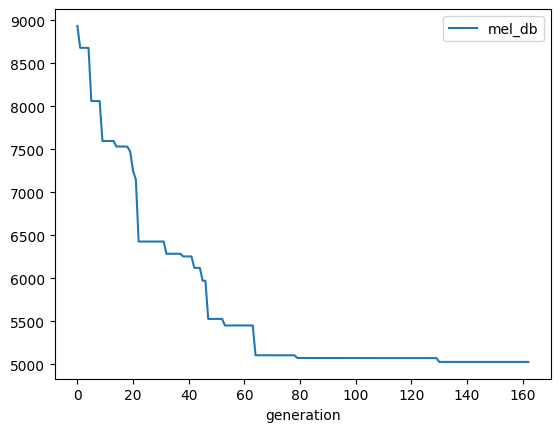

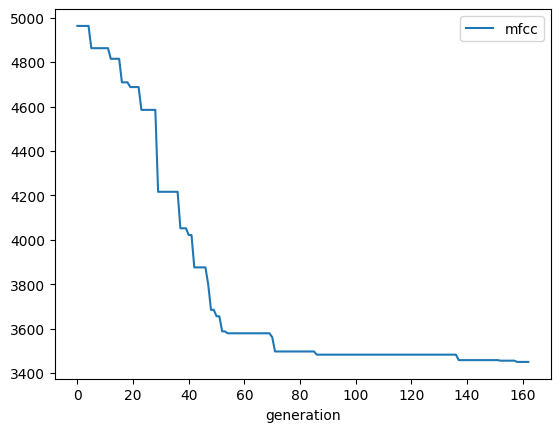

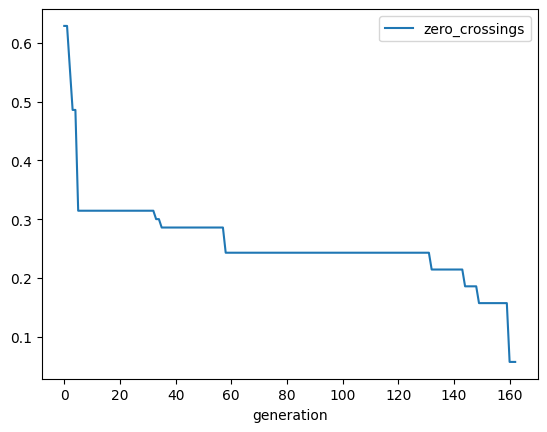

In [168]:
features = config['evolutionary_algorithm']['fitness_function']['feature']
for fitness_index in range(fitness_count):
    df.groupby("generation")[[f'fitness_{fitness_index}']].min().plot(label=features[fitness_index], y=f'fitness_{fitness_index}')
    

<AxesSubplot: xlabel='generation'>

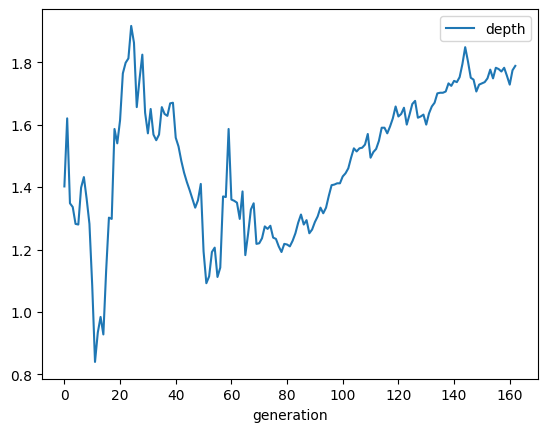

In [169]:
df.groupby("generation")[['depth']].mean().plot()

## Visualize population & individuals

### Ground Truth

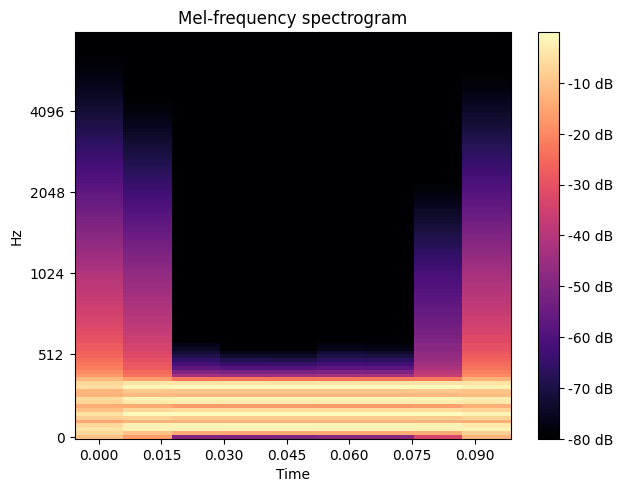

In [170]:
label_audio_name = config['target_audio']['name']
label_audio_path = "../sounds/" + label_audio_name + ".aiff"
label_audio, _ = librosa.load(label_audio_path, sr=sample_rate)

duration = librosa.get_duration(y=label_audio, sr=sample_rate)

audio_widget = ip_disp.Audio(
    data=label_audio, 
    rate=sample_rate
)
display(audio_widget)

mel_spectrogram_label = librosa.feature.melspectrogram(y=label_audio, sr=sample_rate)
mel_spectrogram_decibel_label = librosa.power_to_db(mel_spectrogram_label, ref=np.max)
figure, ax = plt.subplots()
img = librosa.display.specshow(
    mel_spectrogram_decibel_label,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=8000,
    ax=ax
)
figure.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
ax.set(title='Mel-frequency spectrogram')
plt.show()

### Solutions

In [171]:
generation_widget = widgets.IntSlider(value=0, min=0, max=last_generation, description='Generation')
individual_selector = widgets.BoundedIntText(value=0, min=0, max=population_size - 1, description='Individual')
def randomize_individual(event):
    individual_selector.value = random.randrange(population_size)

individual_randomizer = widgets.Button(description="Randomize")
individual_randomizer.on_click(randomize_individual)
individual_widget = widgets.HBox([individual_selector, individual_randomizer])

# TODO: Stuff here could be done much more performant using libraries like ipympl, but it's not worth the time investment right now. https://mpl-interactions.readthedocs.io/en/stable/index.html

In [172]:
def plot_pareto_front(generation, marked_individual):
    population = df.loc[df.generation == generation]
    objectives = population[['fitness_0', 'fitness_1']]
    
    pf_figure, pf_ax = plt.subplots()
    pf_ax.set_xlabel("Fitness 0")
    pf_ax.set_ylabel("Fitness 1")
    pf_ax.set_title('Pareto Front')
    
    pf_ax.autoscale(tight=True)
    pf_figure.tight_layout()

    # Add the origin/utopian point
    pf_ax.scatter(0, 0, c="k", marker="+", s=100)

    unmarked = objectives.loc[population.individual != marked_individual]
    marked = objectives.loc[population.individual == marked_individual]
    
    # Add the individual results
    scatter_plot = pf_ax.scatter(
        unmarked['fitness_0'], 
        unmarked['fitness_1'], 
        marker=".", 
        s=48,
        # Set color according to depth map
        #c=population.depth
        color="blue"
    )

    scatter_plot = pf_ax.scatter(
        marked['fitness_0'], 
        marked['fitness_1'], 
        marker=".", 
        s=48,
        color="red"
    )
    
    #plt.colorbar(scatter_plot, ax=ax, format='%d layers')
    
    plt.show()

pareto_front_widget = widgets.interactive_output(plot_pareto_front, {'generation': generation_widget, 'marked_individual': individual_selector})

In [173]:
def plot_histogram(generation, marked_individual):
    population = df.loc[(df.generation == generation) & (df.fitness_0 < np.inf)]
    
    objective = population[['fitness_0']]
    
    figure, ax = plt.subplots()

    # Add the individual results
    histogram = ax.hist(objective, bins=int(population_size/3))
        
    ax.set_xlabel("Fitness 0")
    ax.set_ylabel("Count")
    ax.set_title('Fitness Histogram')

    ax.autoscale(tight=True)
    plt.tight_layout()
    
    plt.show()

fitness_histogram_widget = widgets.interactive_output(plot_histogram, {'generation': generation_widget, 'marked_individual': individual_selector})

In [174]:
def synth_expr_to_synth_def(synth_expr, index, primitive_set):
    builder = SynthDefBuilder()
    with builder:
        synth_out = eval(
            synth_expr,
            primitive_set.context,
            {}
        )

        # Stopgap to avoid piping something that is just a constant into Out.ar, which causes a SC segfault
        if isinstance(synth_out, numbers.Number):
            return None

        # Convert a control rate root node to audio rate to avoid a segfault
        if synth_out.calculation_rate == CalculationRate.CONTROL:
            synth_out = K2A.ar(source=synth_out)

        # Direct each synth to its own output bus
        Out.ar(bus=index, source=synth_out)

    return builder.build(name="synth_" + str(index))

def individual_to_sound(
    individual,
    primitive_set,
    duration,
    sampling_rate,
    temporary_path="/tmp/synthesis/",
    sc_executable_path="../SuperCollider/installation/bin/scsynth"
):
    # Convert the individual trees to synth definitions (or None, for invalid individuals)
    synth_definition = synth_expr_to_synth_def(individual, 0, primitive_set)
    
    output_audio, exit_code = synthesize_sounds(
        # Filter out all invalid synth defs
        [synth_definition],
        duration,
        channel_count=1,
        sampling_rate=sampling_rate,
        temporary_path=temporary_path,
        sc_executable_path=sc_executable_path
    )

    if exit_code != 0:
        print("Error: Synthesis produced exit code " + str(exit_code))
        print("Synths:")
        [print(str(synth)) for synth in synth_definitions]
        exit(1)

    return output_audio

def inspect_individual(generation, individual):
    attributes = df.loc[(df.generation == generation) & (df.individual == individual)]
    
    attribute_output = widgets.Output()
    with attribute_output:
        if use_multiple_objectives:
            display(attributes[['fitness_0', 'fitness_1', 'depth', 'valid']])
        else:
            display(attributes[['fitness_0', 'depth', 'valid']])
        
        display(attributes['expression'].iloc[0])

    audio = individual_to_sound(attributes.iloc[0]['expression'], primitive_set, duration, sample_rate)
    audio_output = widgets.Output()
    with audio_output:
        audio_widget = ip_disp.Audio(
            data=audio, 
            rate=sample_rate
        )
        display(audio_widget)
    
    # Show Mel Spectrogram
    mel_output = widgets.Output()
    #mel_output.clear_output()
    with mel_output:
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_spectrogram_decibel = librosa.power_to_db(mel_spectrogram, ref=np.max)
        figure, ax = plt.subplots()
        img = librosa.display.specshow(
            mel_spectrogram_decibel,
            x_axis='time',
            y_axis='mel',
            sr=sample_rate,
            fmax=8000,
            ax=ax
        )
        figure.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        ax.set(title='Mel-frequency spectrogram')
        plt.show()

    mel_delta_output = widgets.Output()
    with mel_delta_output:
        delta = np.abs(mel_spectrogram_decibel_label - mel_spectrogram_decibel)
        figure, ax = plt.subplots()
        img = librosa.display.specshow(
            delta,
            x_axis='time',
            y_axis='mel',
            sr=sample_rate,
            fmax=8000,
            ax=ax
        )
        figure.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        ax.set(title='Delta to Label')
        plt.show()
        
    
    # Render the individual using graphviz
    synth_def = synth_expr_to_synth_def(attributes.iloc[0]['expression'], 0, primitive_set)
    uqbar_graph = synth_def.__graph__()
    graph_string = format(uqbar_graph, "graphviz")
    graph = pgv.AGraph(graph_string)
    png_image = graph.draw(format='png', prog="dot")
    image_widget = widgets.Image(value=png_image, format='png')
    
    
    grid = widgets.GridspecLayout(6, 2, height='700px')
    grid[0, 1] = attribute_output
    grid[:4, 0] = mel_output
    #grid[4:, 0] = mel_delta_output
    grid[1, 1] = audio_output
    grid[2:, 1] = image_widget
    display(grid)
    
    

interactive_inspector = widgets.interactive_output(inspect_individual, {'generation': generation_widget, 'individual': individual_selector})

In [175]:
save_location= '../results/'
def save_individual(generation, individual, individual_path):
    attributes = df.loc[(df.generation == generation) & (df.individual == individual)]
    audio = individual_to_sound(attributes.iloc[0]['expression'], primitive_set, duration, sample_rate)

    sf.write(individual_path + '_audio.aiff', audio, samplerate=sample_rate, format='aiff')
    
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spectrogram_decibel = librosa.power_to_db(mel_spectrogram, ref=np.max)
    figure, ax = plt.subplots()
    img = librosa.display.specshow(
        mel_spectrogram_decibel,
        x_axis='time',
        y_axis='mel',
        sr=sample_rate,
        fmax=8000,
        ax=ax
    )
    figure.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.tight_layout()
    ax.set(title='Mel-frequency spectrogram')
    plt.savefig(individual_path + '_spectrogram')
    plt.close(figure)

    synth_def = synth_expr_to_synth_def(attributes.iloc[0]['expression'], 0, primitive_set)
    uqbar_graph = synth_def.__graph__()
    graph_string = format(uqbar_graph, "graphviz")
    graph = pgv.AGraph(graph_string)
    png_image = graph.draw(path=individual_path + '_graph.png', format='png', prog="dot")

save_name_widget = widgets.Text(
    value=f"g{generation_widget.value}_i{individual_selector.value}"
)

save_button = widgets.Button(
    description="Save Individual"
)

def save_click(btn):
    save_individual(generation_widget.value, individual_selector.value, save_name_widget.value)


save_button.on_click(save_click)
save_widget = widgets.HBox([save_name_widget, save_button])

In [176]:
n_best = 5
def display_interesting_individuals(generation):
    population = df.loc[(df.generation == generation)]
    
    def best_n(attribute, name, minimization=True):
        fitnesses = population[attribute].to_numpy()
        if minimization:
            best_indexes = np.argpartition(fitnesses, n_best)[:n_best]
            best_indexes = np.sort(best_indexes)
        else:
            best_indexes = np.argpartition(fitnesses, (len(fitnesses) - n_best))[(len(fitnesses) - n_best):]
            best_indexes = np.sort(best_indexes)
        display(f"Best {name} individuals:")
        
        buttons = []
        
        for index in best_indexes:
            def set_index(event, ind=index):
                individual_selector.value = ind
            
            button = widgets.Button(description=str(index))
            button.on_click(set_index)
            buttons.append(button)
        
        display(widgets.HBox(buttons))

    features = config['evolutionary_algorithm']['fitness_function']['feature']
    for fitness_index in range(fitness_count):
        best_n(f'fitness_{fitness_index}', features[fitness_index])
    # best_n('crowding_distance', "Crowding Distance", minimization=False)

interesting_individual_widget = widgets.interactive_output(display_interesting_individuals, {'generation': generation_widget})

In [177]:
display(save_widget)

controls = widgets.VBox([generation_widget, interesting_individual_widget, individual_widget])

generation_widget.value=1
grid = widgets.GridspecLayout(7, 3, height='800px')
grid[0:3, 0] = controls
if use_multiple_objectives:
    grid[3:, 0] = pareto_front_widget
else:
    grid[3:, 0] = fitness_histogram_widget
grid[:, 1:] = interactive_inspector
display(grid)

GridspecLayout(children=(VBox(children=(IntSlider(value=1, description='Generation', max=162), Output(), HBox(…